In [270]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from scipy.special import erf

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.style'] = 'italic'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titley'] = 1.05
plt.rcParams['axes.titlepad'] = -40
plt.rcParams['axes.prop_cycle'] = cycler('color', ['#008080', '#DB803D', '#A6A14D', '#82C9B1', '#F3C887', '#DDD99B'])

# global timestep
DT = 0.001

In [177]:
# Super simple energy functions based on distance
def E_ab(r):
    return(-abs(1/r))

def E_ac(r):
    return(-abs(2/r))

def E_bc(r):
    return(0)

def E_LJ(s, r):
    return(4*1 * ((s/r)**12 - (s/r)**6))

In [204]:
# Force functions (derivatives of the energy functions)
# r is the vector from p to q
def F_ab(r):
    mag = (1/np.linalg.norm(r)**2)
    dir = (-r)/np.linalg.norm(r)
    return(mag*dir)

def F_ac(r):
    mag = (2/np.linalg.norm(r)**2)
    dir = (-r)/np.linalg.norm(r)
    return(mag*dir)

def F_bc(r):
    return np.zeros_like(r)

def F_lj(s, r):
    #mag = 24 * (np.linalg.norm(r)**6 -2) / np.linalg.norm(r)**13
    mag = 48 * (s**12/np.linalg.norm(r)**13 - 0.5 * s**6 / np.linalg.norm(r)**7)
    dir = (-r)/np.linalg.norm(r)
    return(mag*dir)

In [188]:
# Maxwell-boltzmann distribution for generating velocities
kB = 8.31446261815324 #J/KMol
def mb(v, m, T):
    return ((m/1000)/(2*np.pi*kB*T))**(3/2) * (4*np.pi*(v**2)) * np.exp(-((m/1000)*(v**2))/(2*kB*T)) #have to divide molar mass by 1000 to get kg

# Rejection sampling
def sample():
    mn=0 # Lowest value of domain
    mx=3000 # Highest value of domain
    bound=0.004 # Upper bound of PDF value
    while True: # Do the following until a value is returned
       # Choose an X inside the desired sampling domain.
       x=np.random.uniform(mn,mx)
       # Choose a Y between 0 and the maximum PDF value.
       y=np.random.uniform(0,bound)
       # Calculate PDF
       pdf=mb(x, 83, 273)
       # Does (x,y) fall in the PDF?
       if y<pdf:
           # Yes, so return x
           return x
       # No, so loop

In [265]:
class Interaction:

    def __init__(self, particles, function):
        self.particles = particles
        self.function = function

def min_image(p1s, p2s, box):
    p1s = p1s - (np.floor(p1s/box) * box)
    p2s = p2s - (np.floor(p2s/box) * box)
    diff = p1s[np.newaxis,:] - p2s[:,np.newaxis]
    diff = diff - (np.round(diff/box)*box)
    return diff

def inbox(x, box):
    return(((x % box) + box) % box)

In [16]:
# plotting function
def plot_configuration(points, bounds=np.array([[],[]]), kwdict={}):

    fig, ax = plt.subplots()
    plt.axis('scaled')
    x_min = y_min = 1000
    x_max = y_max = -1000
    mid = np.zeros(2)
    
    for p in points:
        ax.scatter(p[0], p[1], s=3200, **kwdict)

        mid += p
        if p[0] > x_max: x_max = p[0]
        if p[0] < x_min: x_min = p[0]
        if p[1] > y_max: y_max = p[1]
        if p[1] < y_min: y_min = p[1]
    
    if len(bounds[0]) == 0:   
        mid /= len(points)
        x_bound = 1.3*max(np.linalg.norm(mid-x_min), np.linalg.norm(mid-x_max))
        y_bound = 1.3*max(np.linalg.norm(mid-y_min), np.linalg.norm(mid-y_max))
        sq_bound = max(x_bound, y_bound)

        ax.set_xbound(mid[0]-sq_bound, mid[0]+sq_bound)
        ax.set_ybound(mid[1]-sq_bound, mid[1]+sq_bound)

    else:
        ax.set_xbound(bounds[0][0], bounds[0][1])
        ax.set_ybound(bounds[1][0], bounds[1][1])            

    ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
    plt.axis('off')
    plt.autoscale(False)

    return (fig, ax)

def draw_lines(ax, p, q, c='k'):
    ax.plot([p[0], q[0]], [p[1], q[1]], c=c, linestyle='--')


Etot = -3.00


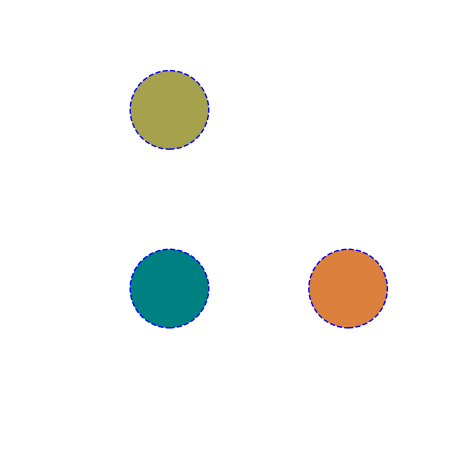

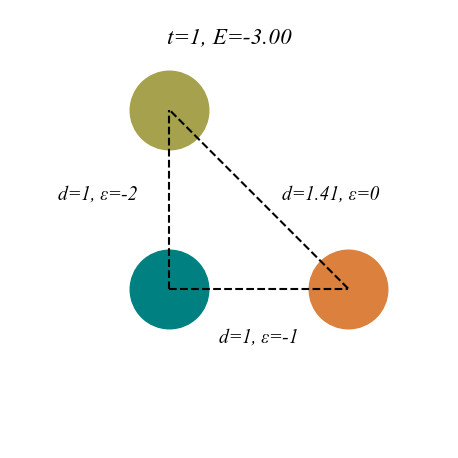

In [17]:
# initialize a system and plot it
a = np.array([0, 0])
b = np.array([1, 0])
c = np.array([0, 1])

# Save an initial one with no annotations as a reference
fig, ax = plot_configuration([a, b, c], kwdict={'edgecolors':'b','linestyle':'--'})
bounds = np.array([ax.get_xbound(), ax.get_ybound()])
plt.tight_layout()
plt.savefig('t0_no_annot.png', dpi=300, transparent=True)

eab = E_ab(a, b)
eac = E_ac(a, c)
ebc = E_bc(b, c)
E = eab+eac+ebc

fig, ax = plot_configuration([a, b, c], bounds)
draw_lines(ax, a, b)
draw_lines(ax, a, c)
draw_lines(ax, b, c)

ax.annotate(f"d={np.linalg.norm(a-b):.0f}, ε={eab:.0f}", np.mean([a, b], axis=0)-[0, 0.3], ha='center')
ax.annotate(f"d={np.linalg.norm(a-c):.0f}, ε={eac:.0f}", np.mean([a, c], axis=0)-[0.4, 0], ha='center')
ax.annotate(f"d={np.linalg.norm(b-c):.2f}, ε={ebc:.0f}", np.mean([b, c], axis=0)+[0.4, 0], ha='center')

ax.set_title(f't=1, E={E:.2f}')



plt.tight_layout()
plt.savefig('t0.png', dpi=300, transparent=True)

print(f"Etot = {eab+eac+ebc:.2f}")

In [269]:
# Verlet integration
def velocity_verlet(xt, vt, at, interaction_masks):
    at1 = np.zeros_like(xt, dtype=np.float64)
    diff = xt[np.newaxis,:] - xt[:,np.newaxis]
    for im in interaction_masks:
        a = np.sum(im.function(diff[np.ix_(im.particles, im.particles)]), axis=0)
        at1[im.particles] += a

    return(xt + vt*DT + 0.5*at*DT, vt + 0.5*at*at1*DT, at1)

In [185]:
# Actually run a simulation

a = np.array([0, 0])
b = np.array([1, 0])
c = np.array([0, 1])
#fig, ax = plot_configuration([a, b, c], bounds)

# turn it into a single numpy array for computation
x0 = np.array([a, b, c])
v0 = np.zeros_like(x0)
a0 = np.zeros_like(x0)

# create force calculation masks
interaction_masks = [Interaction([0,1], F_ab), Interaction([0,2], F_ac), Interaction([1,2], F_bc)]

x = x0
v = v0
a = a0
for i in range(100):
    x, v, a = velocity_verlet(x, v, a, interaction_masks)
    fig, ax = plot_configuration([x[0], x[1], x[2]], bounds)
    eab = E_ab(np.linalg.norm(x[0]-x[1]))
    eac = E_ac(np.linalg.norm(x[0]-x[2]))
    ebc = E_bc(np.linalg.norm(x[1]-x[2]))
    V = eab+eac+ebc
    draw_lines(ax, x[0], x[1])
    draw_lines(ax, x[0], x[2])
    draw_lines(ax, x[1], x[2])
    ax.annotate(f"d={np.linalg.norm(x[0]-x[1]):.2f}, ε={eab:.2f}", np.mean([x[0], x[1]], axis=0)-[0, 0.3], ha='center')
    ax.annotate(f"d={np.linalg.norm(x[0]-x[2]):.2f}, ε={eac:.2f}", np.mean([x[0], x[2]], axis=0)-[0.5, 0.1], ha='center')
    ax.annotate(f"d={np.linalg.norm(x[1]-x[2]):.2f}, ε={ebc:.2f}", np.mean([x[1], x[2]], axis=0)+[0.5, 0.1], ha='center')

    ax.set_title(f't={DT*i:.2f}, V={V:.2f}')
    plt.savefig(f'md_video/{i}.png', dpi=200)
    plt.close(fig)

In [186]:
# Run a simulation with an additional LJ term

a = np.array([0, 0])
b = np.array([1, 0])
c = np.array([0, 1])
#fig, ax = plot_configuration([a, b, c], bounds)

# turn it into a single numpy array for computation
x0 = np.array([a, b, c])
v0 = np.zeros_like(x0)
a0 = np.zeros_like(x0)


def F_abl(r): return(F_ab(r) + F_lj(0.5, r)) 
def F_acl(r): return(F_ac(r) + F_lj(0.5, r)) 
def F_bcl(r): return(F_bc(r) + F_lj(0.5, r)) 

def E_abl(r): return(E_ab(r) + E_LJ(0.5, r)) 
def E_acl(r): return(E_ac(r) + E_LJ(0.5, r)) 
def E_bcl(r): return(E_bc(r) + E_LJ(0.5, r)) 

# create force calculation masks
interaction_masks = [Interaction([0,1], F_abl), Interaction([0,2], F_acl), Interaction([1,2], F_bcl)]

x = x0
v = v0
a = a0
for i in range(100):
    x, v, a = velocity_verlet(x, v, a, interaction_masks)
    fig, ax = plot_configuration([x[0], x[1], x[2]], bounds)
    eabl = E_abl(np.linalg.norm(x[0]-x[1]))
    eacl = E_acl(np.linalg.norm(x[0]-x[2]))
    ebcl = E_bcl(np.linalg.norm(x[1]-x[2]))
    V = eabl+eacl+ebcl
    draw_lines(ax, x[0], x[1])
    draw_lines(ax, x[0], x[2])
    draw_lines(ax, x[1], x[2])
    ax.annotate(f"d={np.linalg.norm(x[0]-x[1]):.2f}, ε={eabl:.2f}", np.mean([x[0], x[1]], axis=0)-[0, 0.3], ha='center')
    ax.annotate(f"d={np.linalg.norm(x[0]-x[2]):.2f}, ε={eacl:.2f}", np.mean([x[0], x[2]], axis=0)-[0.5, 0.1], ha='center')
    ax.annotate(f"d={np.linalg.norm(x[1]-x[2]):.2f}, ε={ebcl:.2f}", np.mean([x[1], x[2]], axis=0)+[0.5, 0.1], ha='center')

    ax.set_title(f't={DT*i:.2f}, V={V:.2f}')
    plt.savefig(f'md_video2/{i}.png', dpi=200)
    plt.close(fig)

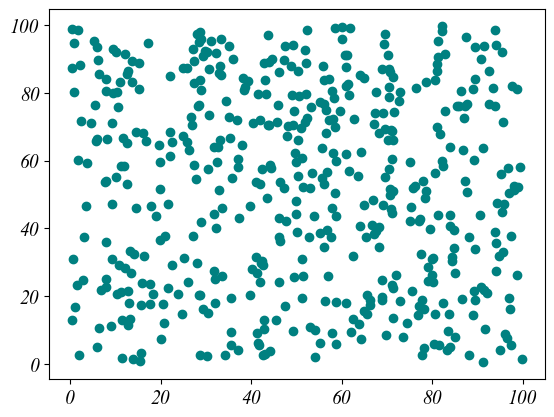

In [274]:
n_particles = 500
start_box = 100
x0 = np.random.random(2*n_particles)*start_box
x0 = x0.reshape((n_particles,2))
v0 = np.empty_like(x0)
s0 = np.empty(n_particles)
for i in range(len(x0)):
    s0[i] = sample() #this is technically speeds for 3D krypton, not 2D

vx = np.array([np.random.uniform(0, s) for s in s0**2])
vy = s0**2-vx
v0[:,0] = np.random.choice([-1, 1], len(vx))*np.sqrt(vx.T)
v0[:,1] = np.random.choice([-1, 1], len(vx))*np.sqrt(vy.T)
a0 = np.zeros_like(x0)

fig, ax = plt.subplots()
ax.scatter(x0[:,0], x0[:,1])

[1.21118279e+06 2.23831841e+06 1.94495508e+06 2.09622373e+06
 9.47665293e+05 1.57114519e+06 2.02844944e+06 2.88059157e+11
 1.83973649e+06 1.77198726e+06 1.33154159e+06 5.78621602e+06
 1.88285820e+06 1.63230637e+06 2.10360633e+06 2.71743348e+06
 1.91681384e+06 1.19923515e+06 1.99825690e+06 1.89134142e+06
 1.99176452e+06 1.17031976e+06 1.94818714e+06 1.36912905e+06
 2.41833788e+06 2.43425074e+06 1.19805008e+06 1.28223717e+06
 2.15520352e+06 2.63299820e+06 2.49434508e+06 2.75105438e+06
 1.98240293e+06 1.33768777e+06 2.62510053e+06 2.13130036e+06
 1.53341192e+06 1.76188385e+06 1.88374823e+06 1.55949877e+06
 1.05267795e+06 1.08052539e+06 1.03744361e+06 1.65320637e+06
 1.99877946e+06 2.53849513e+06 2.09744838e+06 2.14339969e+06
 1.02809525e+06 2.16230756e+06 1.97061462e+06 9.28375792e+05
 8.87926501e+05 1.32087107e+06 1.93523002e+06 1.45807656e+06
 1.35657351e+06 1.51470044e+06 1.49080915e+06 1.53729537e+06
 1.85317816e+06 1.87867770e+06 1.46571204e+06 1.20241522e+06
 2.88058945e+11 2.054976

/var/folders/17/slptg8t94v771jqd8vv_wn6h0000gp/T/ipykernel_27455/3124247453.py:19: RuntimeWarning: invalid value encountered in add
  pe_square += pe_square.T


[ 6.22370870e+03  4.40373632e+03 -6.90643037e+03 -8.57930566e+03
 -5.99773751e+03 -7.46318816e+03 -1.08280799e+04 -1.27698121e+04
  6.99658648e+03  6.85932328e+03 -2.08446800e+03 -3.89191650e+03
 -4.71283856e+03 -6.08989261e+03 -5.25473492e+03 -5.82809985e+03
  6.65246503e+02 -7.89110470e+02  3.39728369e+03  3.23082246e+03
  8.52944828e+03  6.34273528e+03  4.66084923e+03  2.52958086e+03
  2.93442127e+03  1.29444986e+03 -1.21486632e+03 -3.06131330e+03
  5.70924596e+02 -9.39725682e+01 -8.70447612e+03 -9.01998059e+03
 -6.66757630e+02 -1.69286128e+03  6.11972918e+03  4.86506109e+03
  1.04894944e+06  6.37196401e+03 -2.72817984e+03 -4.09305957e+03
 -6.34080326e+03 -6.28318875e+03  8.52448765e+03  6.58498547e+03
 -6.88178140e+03 -5.50718283e+03 -3.32412193e+03 -4.22471566e+03
 -5.52404774e+02 -1.23869113e+03  6.91207995e+02  2.50965998e+03
  1.74748087e+03  1.70288580e+03 -2.03870942e+03 -1.40196544e+03
 -2.82804068e+03 -1.25342402e+03 -3.89006354e+03 -5.28421922e+03
  2.33859597e+12  3.58056

KeyboardInterrupt: 

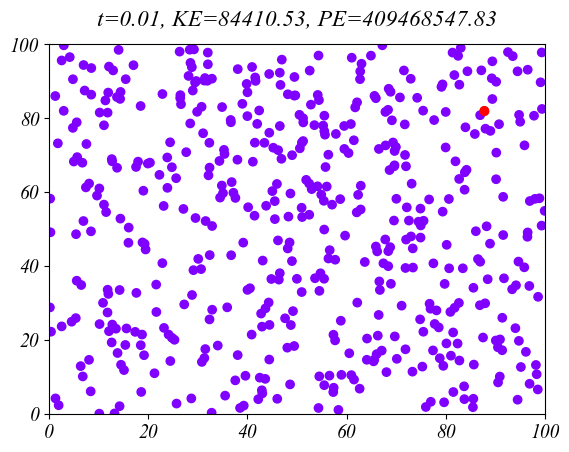

In [288]:
x = x0
v = v0
a = a0

def lj_wrapper(r):
    return(F_lj(1, r))

interaction_masks = [Interaction(np.arange(n_particles), lj_wrapper)]

for i in range(1000):
    x, v, a = velocity_verlet(x, v, a, interaction_masks)
    x = inbox(x, 100)
    ke = np.sum(np.linalg.norm(v)**2)/n_particles
    dists = np.linalg.norm(x[np.newaxis,:] - x[:,np.newaxis], axis=2)[np.tril_indices(len(x),-1)]
    pe = E_LJ(1, dists)
    pe_square = np.empty((len(x), len(x)))
    lti = np.tril_indices(len(x),-1)
    pe_square[lti[0], lti[1]] = pe
    pe_square += pe_square.T
    pe_per_particle = np.sum(pe_square, axis=1)
    print(pe_per_particle)
    #pe = np.sum(E_LJ(1, np.linalg.norm(x[np.newaxis,:] - x[:,np.newaxis], axis=2)[np.tril_indices(len(x),-1)]), axis=1)*2
    pet = sum(pe_per_particle)/n_particles
    if i%10 == 0: print("step:", i)
    fig, ax = fig, ax = plt.subplots()
    ax.scatter(x[:,0], x[:,1], c=pe_per_particle, cmap='rainbow')

    ax.set_xbound(0, 100)
    ax.set_ybound(0, 100)

    ax.set_title(f't={DT*i:.2f}, KE={ke:.2f}, PE={pet:.2f}', y=1.05, pad=0)
    plt.savefig(f'md_video3/{i}.png', dpi=200)
    plt.close(fig)